In [1]:
import numpy as np

from matplotlib import pyplot as plot, colors
%matplotlib inline

from mpl_toolkits import basemap
from netCDF4 import Dataset, num2date

In [2]:
# Input file and data visualization settings
file = 'A202004_CHL_NW_month.nc'
varname = 'chlor_a'
font_size = 40
lw = 4 # line width
# cmin, cmax = 0.01, 100
cmin, cmax = 0.06, 65
# for CHL we use lognorm
norm = colors.LogNorm(cmin, cmax)

# update a few plot properties
plot.rcParams.update({'font.size': font_size})
plot.rcParams['axes.linewidth'] = lw

plot.rcParams['xtick.major.size'] = lw * 3
plot.rcParams['xtick.major.width'] = lw
plot.rcParams['xtick.minor.size'] = lw + 2
plot.rcParams['xtick.minor.width'] = lw / 2

plot.rcParams['ytick.major.size'] = lw * 3
plot.rcParams['ytick.major.width'] = lw
plot.rcParams['ytick.minor.size'] = lw + 2
plot.rcParams['ytick.minor.width'] = lw / 2

plot.rcParams['axes.titlepad'] = 15

cmap_file = 'C:/Users/Eligio/Documents/NPEC/Python/npec_aws/OCDAP/cmaps/chl_cmap.dat'


In [3]:
# Read the dataset and geo-ref data
with Dataset(file, 'r') as nc:
    sds = nc[varname][:] # the output is a numpy masked array
    sds = np.ma.squeeze(sds) # remove singleton dimensions
    label = nc[varname].units.replace('^-3', '$^{-3}$')
    lat = nc['lat'][:]
    lon = nc['lon'][:]
    time = num2date(nc['time'][:], 
                    units=nc['time'].units,
                    calendar=nc['time'].calendar)
    label = nc[varname].long_name.split(',')[0] + f' [{label}]'

In [4]:
def custom_cmap(cmap_file: str):
    """
        The method for reading the color file.
        """
    #  fid = '{}/{}'.format(os.getcwd(), cmap_file)
    colours = list()
    with open(cmap_file, 'r') as f:
        for line in f:
            row = line.split()
            rgb = [eval(row[0]), eval(row[1]), eval(row[2])]
            colours.append(rgb)
            # idy = np.where(rgb == np.max(rgb))[0]
    n = np.array(colours).shape[0]
    levels = (np.array(range(n)) / float(n)).tolist()  # type: list
    levels[-1] = 1.0
    stop = 0
    r, g, b = [], [], []
    while stop < n:
        r.append(tuple([levels[stop], colours[stop][0], colours[stop][0]]))
        g.append(tuple([levels[stop], colours[stop][1], colours[stop][1]]))
        b.append(tuple([levels[stop], colours[stop][2], colours[stop][2]]))
        stop += 1
    colour_map = {
        'red': tuple(r),
        'green': tuple(g),
        'blue': tuple(b)
    }

    return colour_map, levels

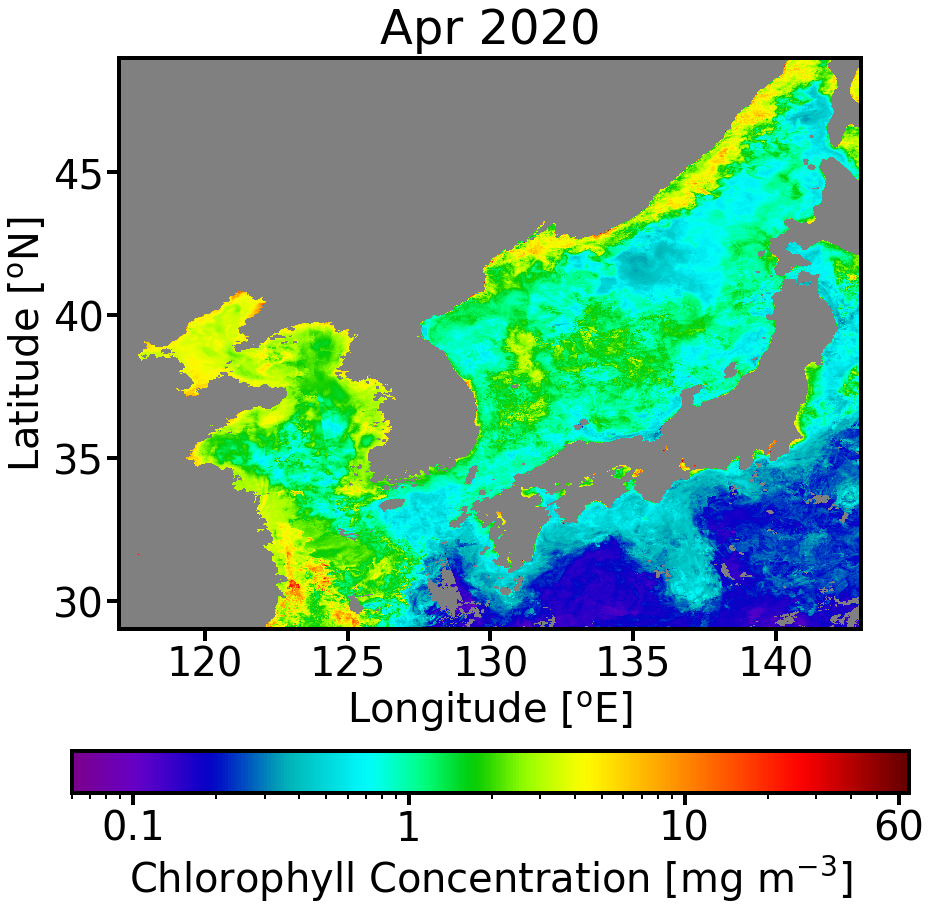

In [5]:
# Visualisation with out basemap
plot.figure(figsize=(15, 15))
# figure bounds
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# Land mask
mask = np.where(~sds.mask, np.nan, 0)
plot.imshow(mask, cmap='gray', vmin=-1, vmax=1, extent=extent)

# Custom colourbar
cmap = colors.LinearSegmentedColormap(
    'custom_cmp', custom_cmap(cmap_file=cmap_file)[0])
plot.register_cmap(cmap=cmap)

# Data 
# ims = plot.imshow(sds, cmap='jet', vmin=cmin, vmax=cmax, extent=extent, norm=norm)
ims = plot.imshow(sds, cmap=plot.get_cmap('custom_cmp'), 
                  vmin=cmin, vmax=cmax, extent=extent, norm=norm)

# Colourbar
cb = plot.colorbar(ims, orientation='horizontal', aspect=20, label=label, format='%g')
cb.set_ticks([0.1, 1, 10, 60])
# print(dir(cb))
# cb.ax.get_xaxis().set_tick_params(which='minor', length=10, width=lw / 2)

# Figure labels
plot.xlabel('Longitude [$^\mathregular{o}$E]')
plot.ylabel('Latitude [$^\mathregular{o}$N]')
plot.yticks(range(30, 50, 5))
plot.title(time[0].strftime('%b %Y'))

# save to file
svf = f'{file[:-3]}.png'
plot.savefig(svf, dpi=300)

# close
# plot.close()

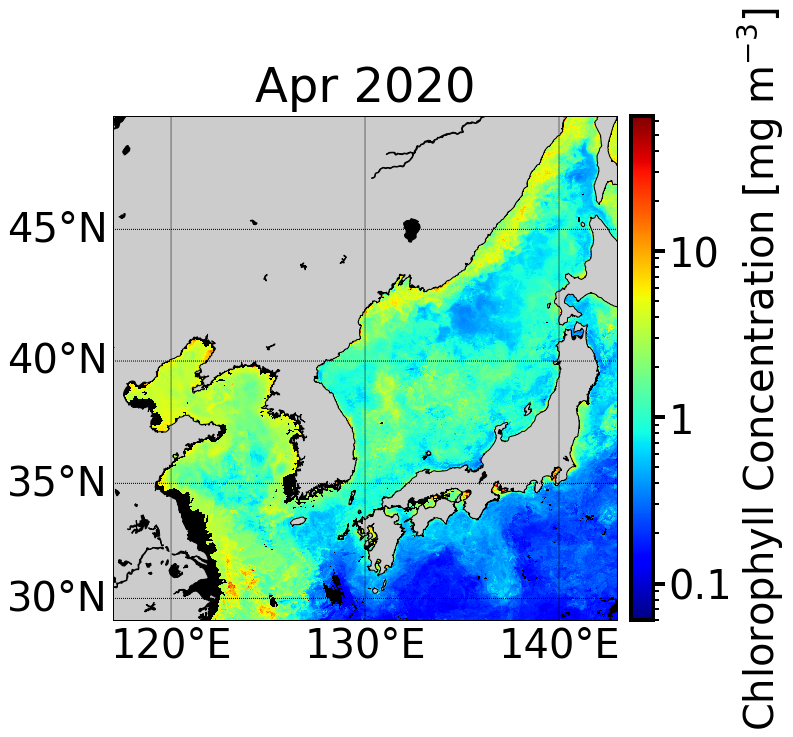

In [6]:
# Visualisation with basemap
if len(lon.shape) == 1:
    lon, lat = np.meshgrid(lon, lat)
lon_0, lat_0 = (lon.min() + lon.max()) / 2, (lat.min() + lat.max()) / 2
m = basemap.Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(), 
                    urcrnrlon=lon.max(), urcrnrlat=lat.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')
# optional, to change the figure size
fig = plot.figure(figsize=(10, 10 * m.aspect))
ax = fig.add_axes([0.08, 0.1, 0.7, 0.7], facecolor='white') 

mx, my = m(lon, lat)
pm = m.pcolormesh(mx, my, sds, norm=norm, cmap=plot.cm.jet)
plot.title(time[0].strftime('%b %Y'))

# colourbar with axes set to match figure size
cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
# cb.ax.tick_params(width=2, length=4)
cb.set_ticks([0.1, 1, 10, 100])

plot.sca(ax)  # make the original axes current again
plot.clim(cmin, cmax)

m.drawparallels(range(30, 50, 5), labels=[True, False, False, False])
m.drawmeridians(range(120, 150, 10), labels=[0, 0, 0, 1])
m.fillcontinents(lake_color='black')  # Fill the continents ',
m.drawmapboundary(fill_color='black')  # Fill the globe with a blue color
m.drawcoastlines()
            
# to visualise
plot.show()